<a href="https://colab.research.google.com/github/QuantumQist/Kawa_w_Teorii/blob/main/AutoencoderYT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import dependencies

In [ ]:
import torch, torchvision
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random

import plotly.express as px
import pandas as pd

# 2. Prepare the data

Data: 0, 1 and 2 numbers from MNIST dataset.

In [ ]:
%%capture

# Import MNIST
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,
    transform = torchvision.transforms.ToTensor(),
    download = True
)
test_data = torchvision.datasets.MNIST(
    root = 'data',
    train = False,
    transform = torchvision.transforms.ToTensor(),
    download = True
)

In [ ]:
# Pick target labels
target_labels = torch.tensor([0,1,2])

# Prepare masks
train_target_mask = torch.isin(train_data.targets, target_labels)
test_target_mask = torch.isin(test_data.targets, target_labels)

# Prepare data subsets
masked_train_data = torch.utils.data.Subset(train_data, torch.where(train_target_mask)[0])
masked_test_data = torch.utils.data.Subset(test_data, torch.where(test_target_mask)[0])

In [ ]:
BATCH_SIZE = 64

# Prepare dataloaders
train_dataloader = torch.utils.data.DataLoader(
    dataset = masked_train_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset = masked_test_data,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

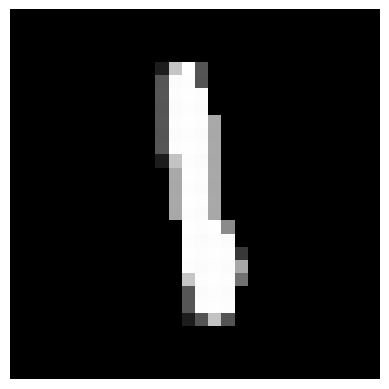

In [ ]:
IDX = 67
image, label = masked_train_data[IDX]

image = image.squeeze().numpy()
plt.imshow(image, cmap="gray")
plt.axis(False)
plt.show()

# 3. Prepare the model.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 16),
            nn.GELU(),
            nn.Linear(16, 3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.GELU(),
            nn.Linear(16,64),
            nn.GELU(),
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Linear(128,784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return torch.reshape(decoded, x.shape)

In [ ]:
# Setup new network
model = AutoEncoder()

# 4. Evaluate the untrained model

* Plot autoencoder output

* Encoder output for test dataset.

In [ ]:
def plot_output(model, dataset, idx):
    """
    Plots the input image from the provided dataset and the output of the model.
    """
    model.eval()

    image, label = dataset[idx]

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image.squeeze().numpy(), cmap = "gray")

    with torch.inference_mode():
        output = model(image)

    axs[1].imshow(output.squeeze().numpy(), cmap = "gray")

    axs[0].set_title("Input")
    axs[1].set_title("Output")

    for i in range(2):
        axs[i].axis(False)

    plt.show()

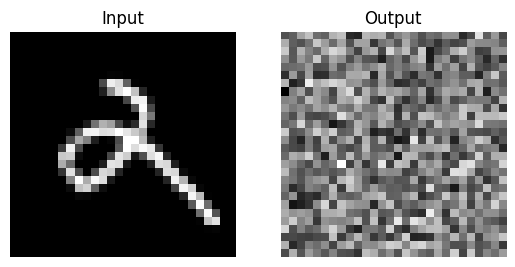

In [ ]:
plot_output(model, masked_test_data, 42)

In [ ]:
def plot_encoder_output(model, dataset, num_elements = 200):
    """
    Plots an interactive 3D plot of the encoder's output.

    Parameters:
    - model - model of the auotencoder
    - dataset - data used for evaluation
    - num_elements - number of input images to be evaluated
    """
    model.eval()

    encoded_data = []
    labels = []

    for idx in range(num_elements):
        image, label = dataset[idx]

        with torch.inference_mode():
            encoded = model.encoder(image)

        encoded_data.append( encoded.squeeze().numpy() )
        labels.append(str(label))

    df = pd.DataFrame(encoded_data, columns = ['x', 'y', 'z'])
    df['label'] = labels

    fig = px.scatter_3d(df, x = 'x', y = 'y', z = 'z', color = df['label'],
                        opacity = 0.2, width = 800, height = 800)
    fig.show()

In [ ]:
plot_encoder_output(model, masked_test_data)

# 5. Train the model

  0%|          | 0/20 [00:00<?, ?it/s]

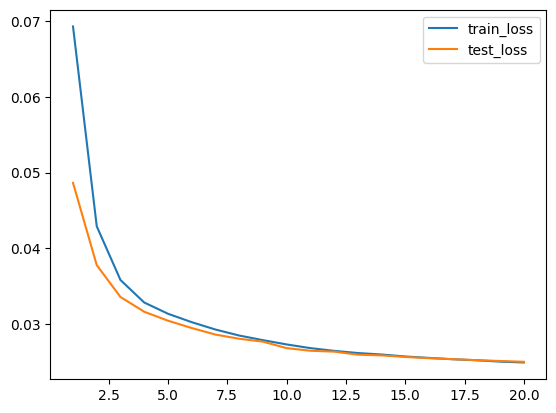

In [ ]:
EPOCHS = 20

# Setup new network
model = AutoEncoder()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_loss, test_loss = [], []

for epoch in tqdm(range(EPOCHS)):
    epoch_train_loss, epoch_test_loss = 0, 0

    # Training step
    model.train()
    for batch, (X, _) in enumerate(train_dataloader):
        # Forward pass
        output = model(X)
        # Compute the loss
        loss = loss_fn(output, X)
        epoch_train_loss += loss.item()
        # Zero gradients
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Optimizer
        optimizer.step()
    train_loss.append(epoch_train_loss / len(train_dataloader))

    # Test step
    model.eval()
    for batch, (X, _) in enumerate(test_dataloader):
        # Forward pass
        with torch.inference_mode():
            output = model(X)
        # Compute the loss
        loss = loss_fn(output, X)
        epoch_test_loss += loss.item()
    test_loss.append( epoch_test_loss / len(test_dataloader))

plt.plot(range(1, EPOCHS + 1), train_loss, label = "train_loss")
plt.plot(range(1, EPOCHS + 1), test_loss, label = "test_loss")
plt.legend()
plt.show()

# 6. Evaluate the trained model

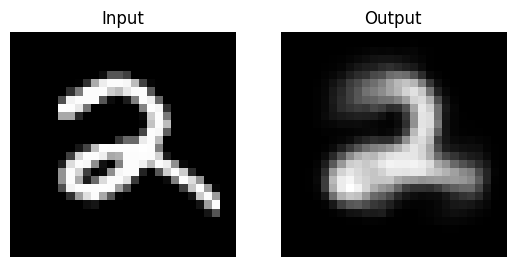

In [ ]:
RANDOM_IDX = random.randint(0, len(masked_test_data) - 1)
plot_output(model, masked_test_data, RANDOM_IDX)

In [ ]:
plot_encoder_output(model, masked_test_data, 1000)